# Linear Dynamic Harmonic Regression (LDHR)

__Parece que los notebooks no están muy perfecionados (o mi instalación tiene problemas). Algunos comandos fallan la primera vez que se ejecutan.__

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [1]:
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [2]:
pkg load control

Cargamos los datos de la serie _"lineas aéreas"_

In [3]:
load airpas

Por comodidad vamos a generar la variable 'y' con los mismos datos (es más cómodo escribir `y` que escribir `airpas`)

In [4]:
y = airpas;

y ahora vamos a representar los datos de la serie de líneas aéreas. Con la siguiente celda de código se genera una figura aparte en una ventana.

In [5]:
figure(1)
grid on
hold on
title('Pasajeros de lineas aereas') % fallan los acentos
plot(airpas, 'r')

In [6]:
#close(1) % si generamos la figura en una ventana y la queremos cerrar después

Si queremos que la figura se muestre dentro del propio Notebook de Jupyter, es necesario incluir lo siguiente: `%plot --format png`

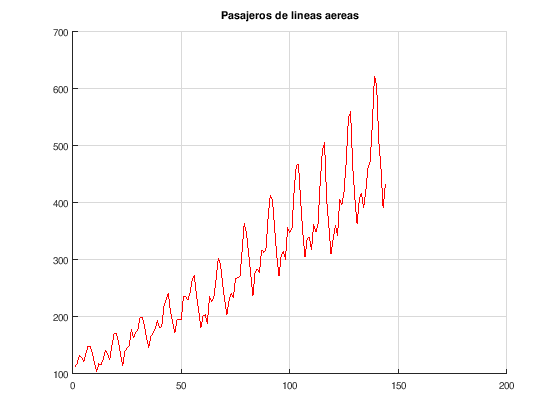

In [7]:
%plot --format png
grid on
hold on
title('Pasajeros de lineas aereas') % fallan los acentos
plot(airpas, 'r')

En `PaP` guadaremos un vector con los periodos correspondientes a la estacionalidad para datos mensuales:

In [8]:
PaP=12./(0:6)

PaP =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000    2.0000



esta serie es un tanto especial, pues el pico espectral correspondiente al periodo 2 es muy ténue (o inexistente), por ello vamos a poner dos ceros para ese componente DHR (para que no trate de identificarlo). Si no lo hacemos así, identificará un modelo para la tendencia más volatil al tratar de ajustar un componente a las oscilaciones de periodo 2 (con la serie en logaritmos si se identifica un modelo IRW para la tendencia incluso si incormporamos el componente de periodo 2).

In [9]:
TVPaP=[1 1 1 1 1 1 0;1 0 0 0 0 0 0]

TVPaP =

   1   1   1   1   1   1   0
   1   0   0   0   0   0   0



In [10]:
[VAR,P,TVP,oar]=autodhr(y,12,[],[],PaP,TVPaP) % la primera vez que lo ejecutemos nos dará unos warnings (luego no)

VAR =

   23.5168    0.2691    6.6372    1.7719    0.4603    0.4891    0.3100         0

P =

       Inf   12.0000    6.0000    4.0000    3.0000    2.4000         0

TVP =

   1   1   1   1   1   1   0
   1   0   0   0   0   0   0

oar = 31


Podemos calcular los ratios de varianzas (NVR) del siguiente modo:

In [11]:
NVR=VAR(2:8)./VAR(1)

NVR =

   0.0114   0.2822   0.0753   0.0196   0.0208   0.0132        0



Vamos a filtrar los componentes con el modelo identificado

In [12]:
filt=0;
[trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,filt,0);

Visualicemos los componentes

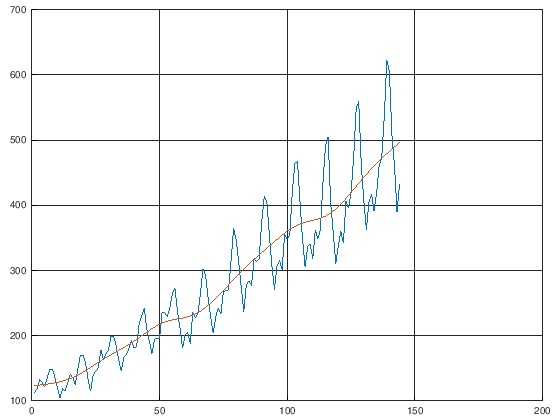

In [13]:
grid on
hold on
plot([y,trend])

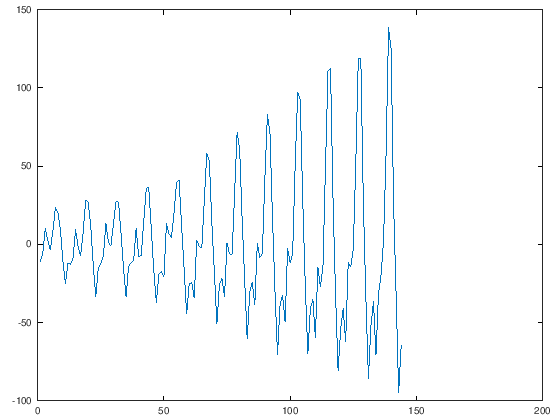

In [14]:
plot([season])

no hemos indicado componente para un ciclo (frecuencia intermedia entre la tendencia (0) y la frecuencia del primer armónico estacional)

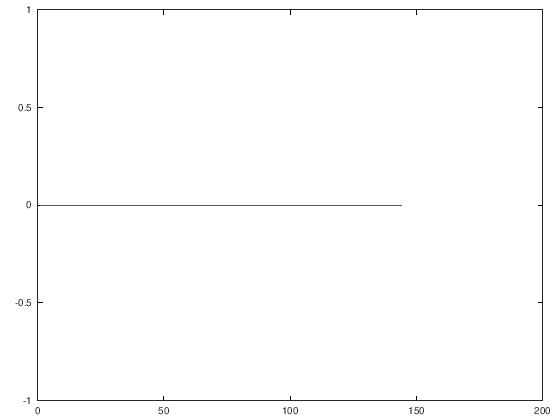

In [15]:
plot(cycle) %% constante cero

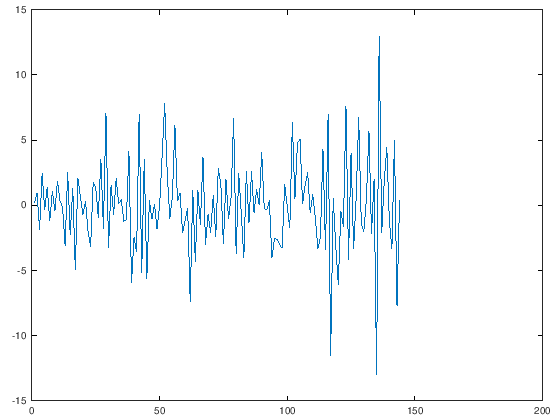

In [16]:
plot(irreg)

Pintemos la serie desestacionalizada `(trend + irreg`)

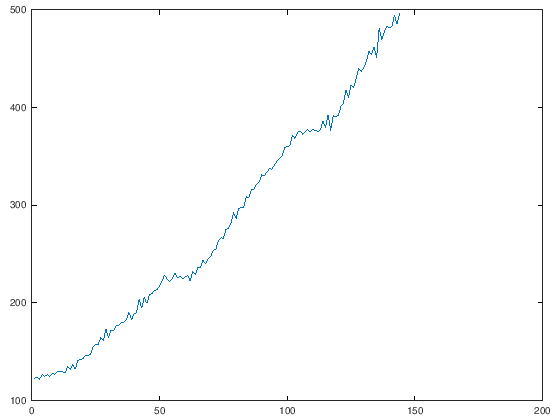

In [17]:
APsa = trend+irreg;
plot(APsa)

In [18]:
filt=2;  % distinta rutina de filtrado que nos devuelve cada armónico por separado
[trend2,seasonH,cycle2,irreg2]=dhrfilt(y,P,TVP,VAR,12,filt,0);

ahora `season` es una matriz cuyas columnas son los armónicos estimados

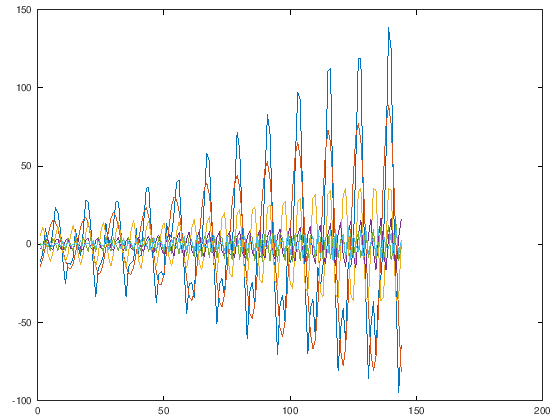

In [19]:
plot(seasonH)

Ahora vemos la primera diferencia de la tendencia estimada:

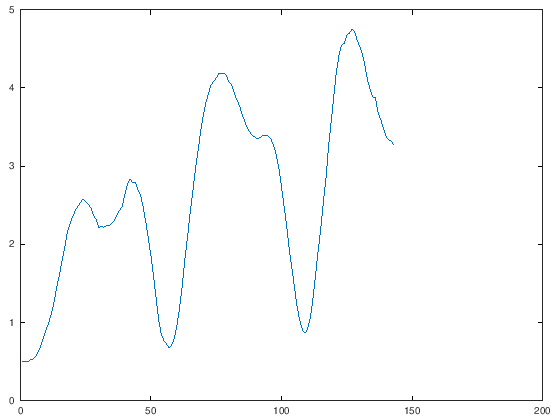

In [20]:
dtrend=diff(trend(:,1));
plot(dtrend)

In [21]:
mkdir estimacionesAP

format bank

function Y = colData (cabecera,data)
    datos = num2str(data,"%5.5f");
    Y = cat(1,strjoin ({cabecera,blanks(size(datos,2)-size(cabecera,2)-1)}), datos);
endfunction

fechas = timefmt4(12,1949,1,size(y,1));

sep=repmat(' ',[size(fechas,1),3]);

save("-ascii", "estimacionesAP/AP.dat",        "airpas")
save("-ascii", "estimacionesAP/APtrend.dat",   "trend")
save("-ascii", "estimacionesAP/APseason.dat",  "season")
save("-ascii", "estimacionesAP/APseasonH.dat", "seasonH")
save("-ascii", "estimacionesAP/APirreg.dat",   "irreg")
save("-ascii", "estimacionesAP/APsa.dat",      "APsa")

AP       = colData("AP",      airpas);
APtrend  = colData("APtrend",  trend);
APseason = colData("APseason",season);
APirreg  = colData("APirreg",  irreg);
APsa     = colData("APsa",      APsa);

AP_COMP_fechas=[fechas, sep, AP, sep, APtrend, sep, APseason, sep, APirreg, sep, APsa];
%save("-ascii", "estimacionesAP/AP_COMP_fechas.dat",      "AP_COMP_fechas")

AP_COMP_fechas

AP_COMP_fechas =

obs            AP          APtrend     APseason    APirreg     APsa     
1949-01-01     112.00000   122.77236   -10.95322   0.18086     122.95322
1949-02-01     118.00000   123.26750   -6.21712    0.94962     124.21712
1949-03-01     132.00000   123.76264   10.09749    -1.86013    121.90251
1949-04-01     129.00000   124.26192   2.29993     2.43815     126.70007
1949-05-01     121.00000   124.79021   -3.45136    -0.33885    124.45136
1949-06-01     135.00000   125.32361   8.33016     1.34623     126.66984
1949-07-01     148.00000   125.89733   23.30990    -1.20723    124.69010
1949-08-01     148.00000   126.52577   20.40972    1.06451     127.59028
1949-09-01     136.00000   127.24739   9.17396     -0.42134    126.82604
1949-10-01     119.00000   128.05969   -10.89419   1.83450     129.89419
1949-11-01     104.00000   128.97474   -25.30495   0.33021     129.30495
1949-12-01     118.00000   129.98083   -11.82675   -0.15408    129.82675
1950-01-01     115.00000   131.10